In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from gym_minigrid.wrappers import *
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
import logging
logging.getLogger('tensorflow').disabled = True
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import gym
import numpy as np
from stable_baselines.common.policies import MlpPolicy
from stable_baselines import PPO2, DQN, TRPO
from utils import *
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
from powersfa import *

Using TensorFlow backend.


In [2]:
coding_length = 16
syst = get_system_contrastive_lean(input_channels=5)
# syst.save_weights(f'predictor_{coding_length}.h5')
syst.load_weights(f'leanpredictor_{coding_length}.h5', by_name=True)

# code predictor
c_p = get_predictor(2, f'leanpredictor_{coding_length}.h5')
rep = Model(inputs=syst.input[0], outputs=syst.get_layer("phi").get_output_at(0))
rep.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp1 (InputLayer)            [(None, 28, 28, 5)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 8)           368       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 16)          1168      
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
phi2 (Dense)                 (None, 16)                272       
_________________________________________________________________
phi (Lambda)                 (None, 16)                0   

In [3]:
import os
import tempfile
import keras
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import model_from_json


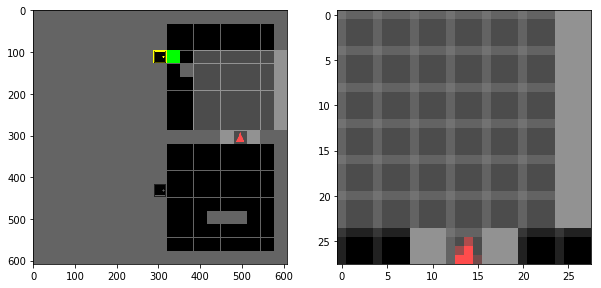

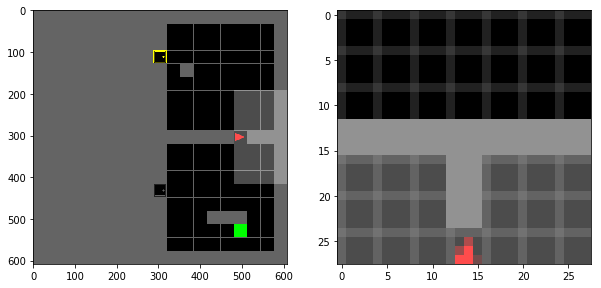

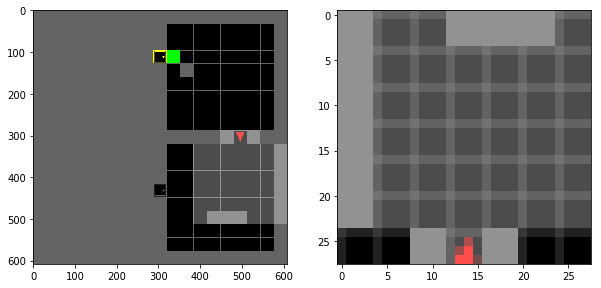

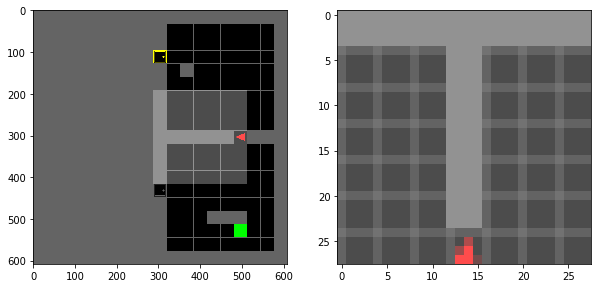

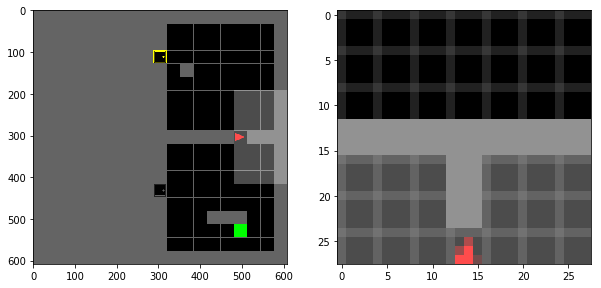

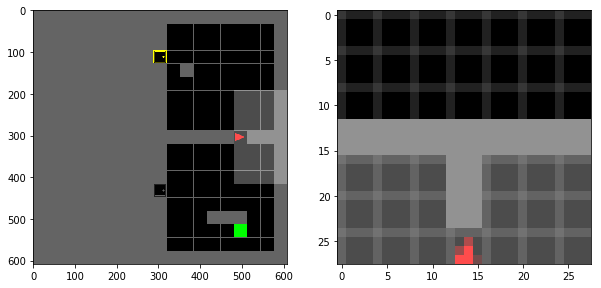

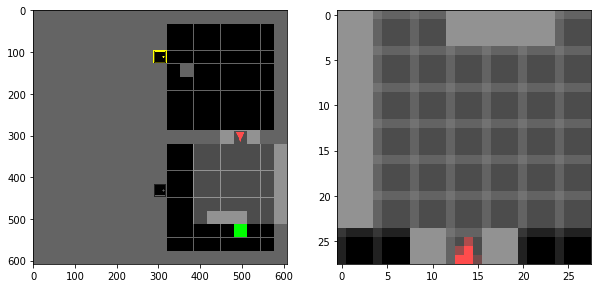

In [4]:
from stable_baselines.common.evaluation import evaluate_policy
proto_env = gym.make('MiniGrid-FourRooms-v0', agent_pos=None)
proto_env = RGBImgPartialObsWrapper(proto_env) # Get pixel observations
proto_env = ImgObsWrapper(proto_env) # Get rid of the 'mission' field
env = DummyVecEnv([lambda: MyMaze(proto_env, representation=rep)])
policy = PPO2("MlpPolicy", env, verbose=0)
for j in range(10):
    obs = proto_env.reset()
    display_combi(proto_env.render(mode="robot"), np.expand_dims(obs[::2, ::2, :3]/255., axis=0))


In [5]:

class MyMaze_simple(gym.Env):
    def __init__(self, env, mode="default"):
        super(MyMaze_simple, self).__init__()
        self.env = env
        self.action_space = self.env.action_space
#         print(self.env.observation_space)
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(56, 56, 5),
            dtype='uint8'
        )
#         self.observation_space = self.env.observation_space
        self.mode = mode

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        return self.env.reset()

    def render(self, mode='human', close=False):
        img = self.env.grid.render(
            32,
            self.env.agent_pos,
            self.env.agent_dir,
            None
        )
        return img

env = DummyVecEnv([lambda: MyMaze_simple(proto_env, predictor=c_p, mode="c", representation=rep)])
policy_kwargs = dict(act_fun=tf.nn.relu, net_arch=[2*49, 2*30])
policy = PPO2("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=0)
policy.save("ppo2_test_history3")
from tensorflow.keras.models import Model
def pred_rew(alpha_f=1.):
    activation2="relu"
    feature_activation = "linear"
    before_dense  = Input(shape=(coding_length, ))
    action_input =  Input(shape=(3,), name='f3')

    concat_layer= Concatenate()([action_input, before_dense])
    reward_dense0 = Dense(int(256*alpha_f), activation=activation2)(concat_layer)
    reward_dense1 = Dense(int(256*alpha_f), activation=activation2)(reward_dense0)
    reward_prediction = Dense(1, activation="sigmoid")(reward_dense1)
    
    rew_net = Model([before_dense, action_input], reward_prediction)
    opt = RMSprop(lr=0.0001, clipvalue=0.5)
    rew_net.compile(optimizer=opt, loss='binary_crossentropy')
    rew_net.load_weights(f'leanpredictor_{coding_length}.h5', by_name=True)

#     except: print("missing f_net model params")
    return rew_net
rew_net = pred_rew()
# rew_net.load_weights("rewnet_32.h5")
_obs_before, _obs, _rws, _actions = ([], [], [], [])


kk is  0
0.0


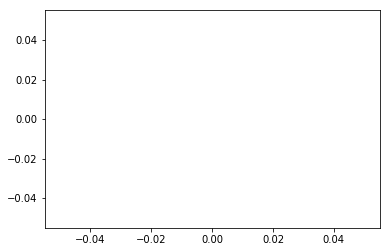

In [6]:
n_trials, n_epochs, n_tests = (1, 1, 1)#00)
means = np.zeros((n_trials, n_epochs, n_tests))
targets = []
for k in range(n_trials):
    env = DummyVecEnv([lambda: MyMaze_simple(proto_env)])
    policy = PPO2("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=0)
    for j in range(n_epochs):
        env = DummyVecEnv([lambda: MyMaze_simple(proto_env)])
        lens = []
        for kk in range(n_tests):
            if kk%5==0:
                print("kk is ", kk)
            env = DummyVecEnv([lambda: MyMaze_simple(proto_env)])
            obs = env.reset()
            action = get_experimental_action(j, np.infty, policy, obs, n_actions=3)
            obs, reward, done, _ = env.step(action)
            d_env_rew, d_actions, terminating_step = perform_rollout(env, j, np.infty, policy, obs, n_actions=3)
#             print(obs.shape)
            means[k, j, kk] = sum(d_env_rew)
            targets.append(obs[0, 0, 0, 4])
        print(means[k, j, :].mean())
np.save("own_means_squeeze_a.npy", means)
plt.errorbar(list(range(means.shape[1])), means.mean(axis=0).mean(axis=1), means.mean(axis=0).std(axis=1))
plt.show()


(7, 7, 3)
[0 1 2 5]


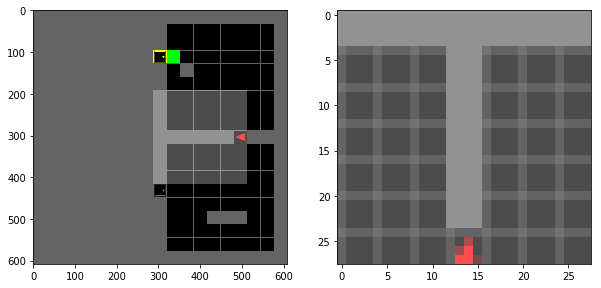

[0.06 0.71]


In [7]:
print(proto_env.gen_obs()['image'].shape)
obs = proto_env.reset()

proto_env.gen_obs()['image'][0, :, :]
for i in range(3):
    img = proto_env.gen_obs()['image']
print(np.unique(img))
display_combi(proto_env.render(mode="robot"), np.expand_dims(obs[::2, ::2, :3]/255., axis=0))
# img = img.transpose((1,2,0))
# plt.imshow(img/5.)
# plt.show()
rgb_weights = [0.2989, 0.5870, 0.1140]
grayscale_image = np.dot(img[...,:3], rgb_weights)/5.
print(np.unique(grayscale_image))
# d_env_rew = np.array(d_env_rew)[:]
grayscale_image[grayscale_image>0.5]=1
grayscale_image[grayscale_image<0.5]=0
plt.imshow(np.flipud(np.rot90(grayscale_image)), cmap="gray")
plt.show()

In [12]:
policy.save("ppo2_test_history")
_GPSes = []
squeeze=True
warmup = 0


In [20]:
#baseline learning using our a controller with a similar size as ours
reward_array = np.zeros((5, 20, 40))
for k in range(reward_array.shape[0]):
    env = DummyVecEnv([lambda: MyMaze_simple(proto_env)])
    policy_baseline = PPO2("CnnPolicy", env, verbose=0)
    policy_baseline.save("ppo2_baseline")

    for j in range(reward_array.shape[1]):
        env =DummyVecEnv([lambda: MyMaze_simple(proto_env)])
        policy_baseline.learn(total_timesteps=max(10000, int(100*(j/4.))))
        lens, rews = ([], [])
        for kk in range(reward_array.shape[2]):
            obs = env.reset()
            warmup2 = 0
            action = get_experimental_action(j, warmup2, policy_baseline, obs, n_actions=3)[0]
            obs, reward, done, _ = env.step([action])
            d_env_rew, d_actions, terminating_step = perform_rollout(env, j, warmup2, policy_baseline, obs, n_actions=3)
            lens.append(len(d_env_rew))
            rews.append(sum(d_env_rew))
            reward_array[k, j, kk] = sum(d_env_rew)
        lens = np.array(lens)
        rews = np.array(rews)
        print("j is ", j, " mean reward is: ", rews.mean())

j is  0  mean reward is:  0.37818
j is  1  mean reward is:  0.11538376
j is  2  mean reward is:  0.3396325
j is  3  mean reward is:  0.27068502
j is  4  mean reward is:  0.05505375
j is  5  mean reward is:  0.08766125
j is  6  mean reward is:  0.0140424995
j is  7  mean reward is:  0.18961875
j is  8  mean reward is:  0.15915126
j is  9  mean reward is:  0.1849475
j is  10  mean reward is:  0.19035
j is  11  mean reward is:  0.4419275
j is  12  mean reward is:  0.0
j is  13  mean reward is:  0.0420125
j is  14  mean reward is:  0.0
j is  15  mean reward is:  0.28909248
j is  16  mean reward is:  0.34159
j is  17  mean reward is:  0.37735
j is  18  mean reward is:  0.6619325
j is  19  mean reward is:  0.62591
j is  0  mean reward is:  0.3511575
j is  1  mean reward is:  0.0
j is  2  mean reward is:  0.44059125
j is  3  mean reward is:  0.17121375
j is  4  mean reward is:  0.03576875
j is  5  mean reward is:  0.11311124
j is  6  mean reward is:  0.06343751
j is  7  mean reward is:  0.230

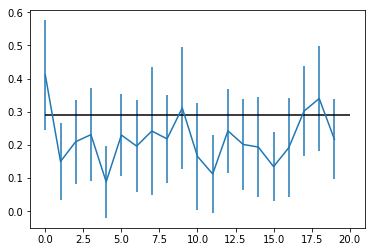

In [29]:
np.save("big_rl_train.npy", reward_array)

plt.errorbar(list(range(reward_array.shape[1])),
             reward_array.mean(axis=0).mean(axis=1), reward_array.mean(axis=0).std(axis=1))
plt.hlines(.29, xmin=0, xmax=20)
plt.show()

plt.errorbar(list(range(reward_array.shape[1])),
             reward_array.max(axis=0).mean(axis=1), reward_array.max(axis=0).std(axis=1))
plt.hlines(.29, xmin=0, xmax=20)
plt.show()

(1, 5, 2)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


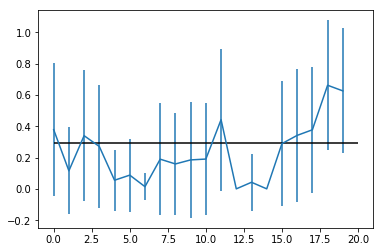

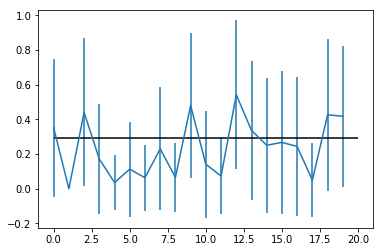

In [25]:
print(means.shape)
print(list(range(reward_array[i, :, :].shape[1])))
for i in range(5):
    plt.errorbar(list(range(reward_array[i, :, :].shape[0])),
                 reward_array[i, :, :].mean(axis=1),
                 reward_array[i, :, :].std(axis=1))
    plt.hlines(.29, 0, 20)
    plt.show()


In [27]:
#baseline learning using our a controller with a similar size as ours
reward_array2 = np.zeros((1, 5, 5))
for k in range(reward_array2.shape[0]):
    env = DummyVecEnv([lambda: MyMaze_simple(proto_env)])
    policy_baseline = PPO2("CnnPolicy", env, verbose=0)
    policy_baseline.save("ppo2_baseline")

    for j in range(reward_array2.shape[1]):
        env =DummyVecEnv([lambda: MyMaze_simple(proto_env)])
        policy_baseline.learn(total_timesteps=max(100000, int(100*(j/4.))))
        lens, rews = ([], [])
        for kk in range(reward_array2.shape[2]):
            obs = env.reset()
            warmup2 = 0
            action = get_experimental_action(j, warmup2, policy_baseline, obs, n_actions=3)[0]
            obs, reward, done, _ = env.step([action])
            d_env_rew, d_actions, terminating_step = perform_rollout(env, j, warmup2, policy_baseline, obs, n_actions=3)
            lens.append(len(d_env_rew))
            rews.append(sum(d_env_rew))
            reward_array2[k, j, kk] = sum(d_env_rew)
        lens = np.array(lens)
        rews = np.array(rews)
        print("j is ", j, " mean reward is: ", rews.mean())

j is  0  mean reward is:  0.30649
j is  1  mean reward is:  0.0
j is  2  mean reward is:  0.665
j is  3  mean reward is:  0.0
j is  4  mean reward is:  0.0


In [57]:
def nature_cnn_smaller(scaled_images, **kwargs):
    """
    CNN from Nature paper.

    :param scaled_images: (TensorFlow Tensor) Image input placeholder
    :param kwargs: (dict) Extra keywords parameters for the convolutional layers of the CNN
    :return: (TensorFlow Tensor) The CNN output layer
    """
    activ = tf.nn.relu
    layer_1 = activ(conv(scaled_images, 'c1', n_filters=8, filter_size=8, stride=4, init_scale=np.sqrt(2), **kwargs))
    layer_2 = activ(conv(layer_1, 'c2', n_filters=16, filter_size=4, stride=2, init_scale=np.sqrt(2), **kwargs))
    layer_3 = activ(conv(layer_2, 'c3', n_filters=16, filter_size=3, stride=1, init_scale=np.sqrt(2), **kwargs))
    layer_3 = conv_to_fc(layer_3)
    return activ(linear(layer_3, 'fc1', n_hidden=64, init_scale=np.sqrt(2)))

#https://stable-baselines.readthedocs.io/en/master/guide/examples.html#custom-policy-network
#https://stable-baselines.readthedocs.io/en/master/_modules/stable_baselines/common/policies.html
import warnings
from itertools import zip_longest
from abc import ABC, abstractmethod
from stable_baselines.common.policies import CnnPolicy, FeedForwardPolicy

import numpy as np
import tensorflow as tf
from gym.spaces import Discrete

from stable_baselines.common.tf_util import batch_to_seq, seq_to_batch
from stable_baselines.common.tf_layers import conv, linear, conv_to_fc, lstm
from stable_baselines.common.distributions import make_proba_dist_type, CategoricalProbabilityDistribution, \
    MultiCategoricalProbabilityDistribution, DiagGaussianProbabilityDistribution, BernoulliProbabilityDistribution
from stable_baselines.common.input import observation_input

class CustomPolicy(FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomPolicy, self).__init__(*args, **kwargs,
                                           cnn_extractor=nature_cnn_smaller,
                                           feature_extraction="cnn")
env = DummyVecEnv([lambda: MyMaze_simple(proto_env)])

model = PPO2(CustomPolicy, env, verbose=0)
paramz = model.get_parameters()
summa = 0
for i in paramz:
    summa += sum(paramz[i].shape)
    print(paramz[i].shape)
print("total number of params: ", summa)
print(env.reset().shape)
a = env.reset()
print(np.unique(a))

model = PPO2("CnnPolicy", env, verbose=0)
paramz = model.get_parameters()
summa = 0
for i in paramz:
    summa += sum(paramz[i].shape)
#     print(paramz[i].shape)
print("total number of params: ", summa)
# print(env.reset().shape)
a = env.reset()
# print(np.unique(a))

(8, 8, 5, 8)
(1, 8, 1, 1)
(4, 4, 8, 16)
(1, 16, 1, 1)
(3, 3, 16, 16)
(1, 16, 1, 1)
(144, 64)
(64,)
(64, 1)
(1,)
(64, 7)
(7,)
(64, 7)
(7,)
total number of params:  642
(1, 56, 56, 5)
[  0   1  33  55  76  99 114 115 146 155 175 235 255]
total number of params:  3626


In [49]:

class MyMaze_simple2(gym.Env):
    def __init__(self, env, mode="default"):
        super(MyMaze_simple2, self).__init__()
        self.env = env
        self.action_space = self.env.action_space
#         print(self.env.observation_space)
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=(56, 56, 5),
            dtype='float32'
        )
#         self.observation_space = self.env.observation_space
        self.mode = mode

    def step(self, action):
        obs, reward, done, _ = self.env.step(action)
        obs[:, :, :3] = obs[:, :, :3]/255.
        return (obs, reward, done, _)

    def reset(self):
        return self.env.reset()

    def render(self, mode='human', close=False):
        img = self.env.grid.render(
            32,
            self.env.agent_pos,
            self.env.agent_dir,
            None
        )
        return img


In [59]:
#baseline learning using our a controller with a similar size as ours
means = np.zeros((3, 20, 10))
for k in range(5):
    env = DummyVecEnv([lambda: MyMaze_simple2(proto_env)])
    policy_baseline = PPO2(CustomPolicy, env, verbose=0)
    policy_baseline.save("ppo2_baseline")

    for j in range(20):
        env =DummyVecEnv([lambda: MyMaze_simple2(proto_env)])
        policy_baseline.learn(total_timesteps=max(5000, int(100*(j/4.))))
        lens, rews = ([], [])
        for kk in range(10):
            obs = env.reset()
            warmup2 = 0
            action = get_experimental_action(j, warmup2, policy_baseline, obs, n_actions=3)[0]
            obs, reward, done, _ = env.step([action])
            d_env_rew, d_actions, terminating_step = perform_rollout(env, j, warmup2, policy_baseline, obs, n_actions=3)
            lens.append(len(d_env_rew))
            rews.append(sum(d_env_rew))
            means[k, j, kk] = sum(d_env_rew)
        lens = np.array(lens)
        rews = np.array(rews)
        print("j is ", j, " mean reward is: ", rews.mean())

j is  0  mean reward is:  0.24442501
j is  1  mean reward is:  0.14096001
j is  2  mean reward is:  0.0
j is  3  mean reward is:  0.0
j is  4  mean reward is:  0.227685
j is  5  mean reward is:  0.0
j is  6  mean reward is:  0.08155
j is  7  mean reward is:  0.14627
j is  8  mean reward is:  0.081819996
j is  9  mean reward is:  0.0
j is  10  mean reward is:  0.14339
j is  11  mean reward is:  0.06436
j is  12  mean reward is:  0.068815
j is  13  mean reward is:  0.0
j is  14  mean reward is:  0.079705
j is  15  mean reward is:  0.53971
j is  16  mean reward is:  0.42314
j is  17  mean reward is:  0.15599
j is  18  mean reward is:  0.33979002
j is  19  mean reward is:  0.15058999
j is  0  mean reward is:  0.315805
j is  1  mean reward is:  0.0
j is  2  mean reward is:  0.0
j is  3  mean reward is:  0.07696
j is  4  mean reward is:  0.14739498
j is  5  mean reward is:  0.0
j is  6  mean reward is:  0.057115
j is  7  mean reward is:  0.28628498
j is  8  mean reward is:  0.271705
j is  9 

IndexError: index 3 is out of bounds for axis 0 with size 3

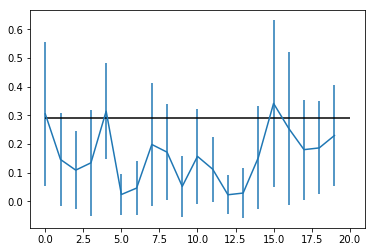

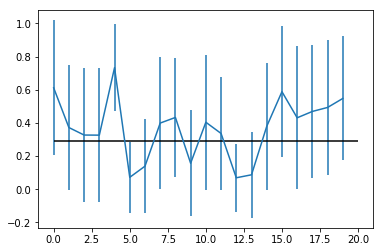

In [60]:
np.save("big_rl_train2.npy", means)

plt.errorbar(list(range(means.shape[1])),
             means.mean(axis=0).mean(axis=1), means.mean(axis=0).std(axis=1))
plt.hlines(.29, xmin=0, xmax=20)
plt.show()

plt.errorbar(list(range(means.shape[1])),
             means.max(axis=0).mean(axis=1), means.max(axis=0).std(axis=1))
plt.hlines(.29, xmin=0, xmax=20)
plt.show()

In [61]:
#baseline learning using our a controller with a similar size as ours
means2 = np.zeros((5, 50, 20))
for k in range(means2.shape[0]):
    env = DummyVecEnv([lambda: MyMaze_simple2(proto_env)])
    policy_baseline = PPO2(CustomPolicy, env, verbose=0)
    policy_baseline.save("ppo2_baseline")

    for j in range(means2.shape[1]):
        env =DummyVecEnv([lambda: MyMaze_simple2(proto_env)])
        policy_baseline.learn(total_timesteps=max(5000, int(100*(j/4.))))
        lens, rews = ([], [])
        for kk in range(means2.shape[2]):
            obs = env.reset()
            warmup2 = 0
            action = get_experimental_action(j, warmup2, policy_baseline, obs, n_actions=3)[0]
            obs, reward, done, _ = env.step([action])
            d_env_rew, d_actions, terminating_step = perform_rollout(env, j, warmup2, policy_baseline, obs, n_actions=3)
            lens.append(len(d_env_rew))
            rews.append(sum(d_env_rew))
            means2[k, j, kk] = sum(d_env_rew)
        lens = np.array(lens)
        rews = np.array(rews)
        print("j is ", j, " mean reward is: ", rews.mean())

j is  0  mean reward is:  0.41263252
j is  1  mean reward is:  0.1733825
j is  2  mean reward is:  0.16499
j is  3  mean reward is:  0.3157375
j is  4  mean reward is:  0.0384575
j is  5  mean reward is:  0.0748225
j is  6  mean reward is:  0.15196249
j is  7  mean reward is:  0.111615
j is  8  mean reward is:  0.1164075
j is  9  mean reward is:  0.16525999
j is  10  mean reward is:  0.1178025
j is  11  mean reward is:  0.2592575
j is  12  mean reward is:  0.16096249
j is  13  mean reward is:  0.1514675
j is  14  mean reward is:  0.1997575
j is  15  mean reward is:  0.12606001
j is  16  mean reward is:  0.14348
j is  17  mean reward is:  0.30747998
j is  18  mean reward is:  0.124287486
j is  19  mean reward is:  0.20178251
j is  20  mean reward is:  0.27957502
j is  21  mean reward is:  0.382415
j is  22  mean reward is:  0.37728
j is  23  mean reward is:  0.44976252
j is  24  mean reward is:  0.5033625
j is  25  mean reward is:  0.39609003
j is  26  mean reward is:  0.3165025
j is  2

j is  31  mean reward is:  0.187585
j is  32  mean reward is:  0.13693249
j is  33  mean reward is:  0.2256825
j is  34  mean reward is:  0.23189251
j is  35  mean reward is:  0.0
j is  36  mean reward is:  0.0358475
j is  37  mean reward is:  0.094875
j is  38  mean reward is:  0.0629875
j is  39  mean reward is:  0.066925004
j is  40  mean reward is:  0.43823752
j is  41  mean reward is:  0.19917251
j is  42  mean reward is:  0.0
j is  43  mean reward is:  0.076645
j is  44  mean reward is:  0.2534925
j is  45  mean reward is:  0.3231575
j is  46  mean reward is:  0.1737425
j is  47  mean reward is:  0.33232
j is  48  mean reward is:  0.17345
j is  49  mean reward is:  0.25734


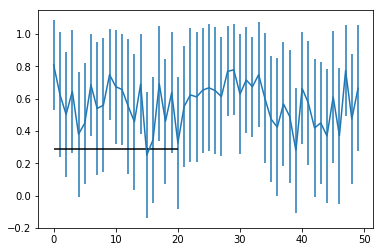

In [62]:
np.save("big_rl_train3.npy", means2)

plt.errorbar(list(range(means2.shape[1])),
             means2.mean(axis=0).mean(axis=1), means2.mean(axis=0).std(axis=1))
plt.hlines(.29, xmin=0, xmax=20)
plt.show()

plt.errorbar(list(range(means2.shape[1])),
             means2.max(axis=0).mean(axis=1), means2.max(axis=0).std(axis=1))
plt.hlines(.29, xmin=0, xmax=20)
plt.show()

In [63]:
#baseline learning using our a controller with a similar size as ours
means3 = np.zeros((5, 50, 20))
for k in range(means2.shape[0]):
    env = DummyVecEnv([lambda: MyMaze_simple2(proto_env)])
    policy_baseline = PPO2("CnnPolicy", env, verbose=0)
    policy_baseline.save("ppo2_baseline")

    for j in range(means2.shape[1]):
        env =DummyVecEnv([lambda: MyMaze_simple2(proto_env)])
        policy_baseline.learn(total_timesteps=max(5000, int(100*(j/4.))))
        lens, rews = ([], [])
        for kk in range(means2.shape[2]):
            obs = env.reset()
            warmup2 = 0
            action = get_experimental_action(j, warmup2, policy_baseline, obs, n_actions=3)[0]
            obs, reward, done, _ = env.step([action])
            d_env_rew, d_actions, terminating_step = perform_rollout(env, j, warmup2, policy_baseline, obs, n_actions=3)
            lens.append(len(d_env_rew))
            rews.append(sum(d_env_rew))
            means3[k, j, kk] = sum(d_env_rew)
        lens = np.array(lens)
        rews = np.array(rews)
        print("j is ", j, " mean reward is: ", rews.mean())

j is  0  mean reward is:  0.4367525
j is  1  mean reward is:  0.1892725
j is  2  mean reward is:  0.109500006
j is  3  mean reward is:  0.0854875
j is  4  mean reward is:  0.3915675
j is  5  mean reward is:  0.1754525
j is  6  mean reward is:  0.468815
j is  7  mean reward is:  0.0
j is  8  mean reward is:  0.0357575
j is  9  mean reward is:  0.0
j is  10  mean reward is:  0.0
j is  11  mean reward is:  0.10599001
j is  12  mean reward is:  0.24789
j is  13  mean reward is:  0.35289
j is  14  mean reward is:  0.478365
j is  15  mean reward is:  0.23351249
j is  16  mean reward is:  0.108622506
j is  17  mean reward is:  0.07412501
j is  18  mean reward is:  0.0484025
j is  19  mean reward is:  0.0430475
j is  20  mean reward is:  0.0
j is  21  mean reward is:  0.0
j is  22  mean reward is:  0.0
j is  23  mean reward is:  0.0
j is  24  mean reward is:  0.0
j is  25  mean reward is:  0.10778999
j is  26  mean reward is:  0.03587
j is  27  mean reward is:  0.0
j is  28  mean reward is:  0

j is  37  mean reward is:  0.0
j is  38  mean reward is:  0.0
j is  39  mean reward is:  0.22176747
j is  40  mean reward is:  0.03254
j is  41  mean reward is:  0.0420125
j is  42  mean reward is:  0.061074995
j is  43  mean reward is:  0.181235
j is  44  mean reward is:  0.0326975
j is  45  mean reward is:  0.12504749
j is  46  mean reward is:  0.1490375
j is  47  mean reward is:  0.2589825
j is  48  mean reward is:  0.11226751
j is  49  mean reward is:  0.36272252


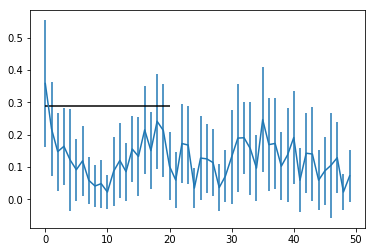

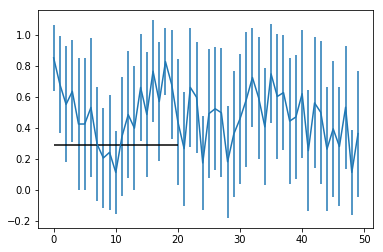

In [64]:
np.save("big_rl_train3.npy", means2)

plt.errorbar(list(range(means3.shape[1])),
             means3.mean(axis=0).mean(axis=1), means3.mean(axis=0).std(axis=1))
plt.hlines(.29, xmin=0, xmax=20)
plt.show()

plt.errorbar(list(range(means3.shape[1])),
             means3.max(axis=0).mean(axis=1), means3.max(axis=0).std(axis=1))
plt.hlines(.29, xmin=0, xmax=20)
plt.show()

In [68]:
#baseline learning using our a controller with a similar size as ours
from stable_baselines import PPO2, DQN, TRPO, PPO1
means4 = np.zeros((3, 20, 10))
for k in range(means4.shape[0]):
    env = DummyVecEnv([lambda: MyMaze_simple2(proto_env)])
    policy_baseline = PPO1("CnnPolicy", env, verbose=0)
    policy_baseline.save("ppo2_baseline")

    for j in range(means4.shape[1]):
        env =DummyVecEnv([lambda: MyMaze_simple2(proto_env)])
        policy_baseline.learn(total_timesteps=max(5000, int(100*(j/4.))))
        lens, rews = ([], [])
        for kk in range(means4.shape[2]):
            obs = env.reset()
            warmup2 = 0
            action = get_experimental_action(j, warmup2, policy_baseline, obs, n_actions=3)[0]
            obs, reward, done, _ = env.step([action])
            d_env_rew, d_actions, terminating_step = perform_rollout(env, j, warmup2, policy_baseline, obs, n_actions=3)
            lens.append(len(d_env_rew))
            rews.append(sum(d_env_rew))
            means4[k, j, kk] = sum(d_env_rew)
        lens = np.array(lens)
        rews = np.array(rews)
        print("j is ", j, " mean reward is: ", rews.mean())

j is  0  mean reward is:  0.54529
j is  1  mean reward is:  0.18316999
j is  2  mean reward is:  0.13835
j is  3  mean reward is:  0.17844501
j is  4  mean reward is:  0.148025
j is  5  mean reward is:  0.08677
j is  6  mean reward is:  0.21711001
j is  7  mean reward is:  0.14942
j is  8  mean reward is:  0.064945
j is  9  mean reward is:  0.1262
j is  10  mean reward is:  0.064315
j is  11  mean reward is:  0.058555
j is  12  mean reward is:  0.132275
j is  13  mean reward is:  0.0
j is  14  mean reward is:  0.0
j is  15  mean reward is:  0.081819996
j is  16  mean reward is:  0.230745
j is  17  mean reward is:  0.0
j is  18  mean reward is:  0.26347
j is  19  mean reward is:  0.23962
j is  0  mean reward is:  0.419
j is  1  mean reward is:  0.086185
j is  2  mean reward is:  0.0
j is  3  mean reward is:  0.075025
j is  4  mean reward is:  0.0
j is  5  mean reward is:  0.0
j is  6  mean reward is:  0.0
j is  7  mean reward is:  0.07669
j is  8  mean reward is:  0.065305
j is  9  mean

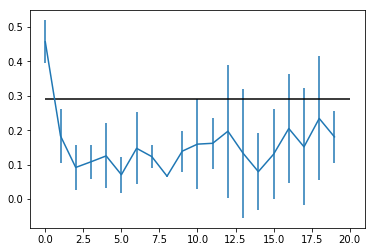

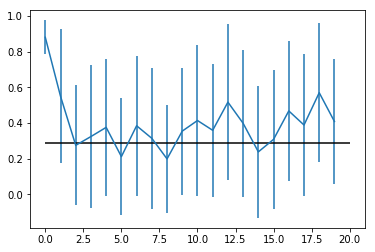

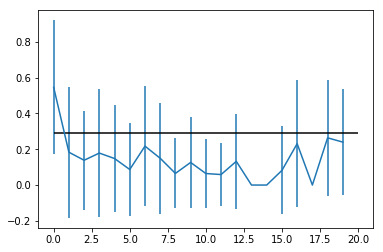

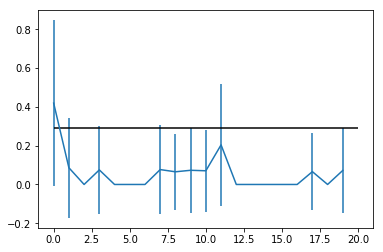

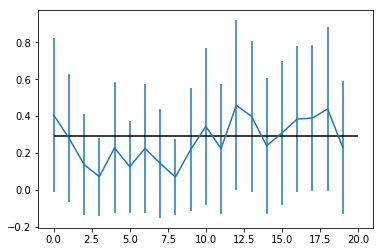

In [71]:

plt.errorbar(list(range(means4.shape[1])),
             means4.mean(axis=2).mean(axis=0), means4.mean(axis=2).std(axis=0))
plt.hlines(.29, xmin=0, xmax=20)
plt.show()

plt.errorbar(list(range(means4.shape[1])),
             means4.max(axis=0).mean(axis=1), means4.max(axis=0).std(axis=1))
plt.hlines(.29, xmin=0, xmax=20)
plt.show()

for i in range(3):
    plt.errorbar(list(range(means4[i, :, :].shape[0])),
                 means4[i, :, :].mean(axis=1),
                 means4[i, :, :].std(axis=1))
    plt.hlines(.29, 0, 20)
    plt.show()

In [114]:
class MyMaze_simpler(gym.Env):
    def __init__(self, env, mode="default"):
        super(MyMaze_simpler, self).__init__()
        self.env = env
        self.action_space = spaces.Discrete(3)#self.env.action_space
#         print(self.env.observation_space)
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=(56, 56, 5),
            dtype='float32'
        )
#         self.observation_space = self.env.observation_space
        self.mode = mode

    def step(self, action):
        obs, reward, done, _ = self.env.step(action)
        obs[:, :, :3] =  obs[:, :, :3]/255.
        return (obs, reward, done, _)

    def reset(self):
        out = self.env.reset()
        out[:, :, :3] = out[:, :, :3]/255.
        return out

    def render(self, mode='human', close=False):
        img = self.env.grid.render(
            32,
            self.env.agent_pos,
            self.env.agent_dir,
            None
        )
        return img


In [116]:
#baseline learning using our a controller with a similar size as ours
import stable_baselines
from stable_baselines import PPO2, DQN, TRPO, PPO1, GAIL, HER
means77 = np.zeros((3, 30, 10))
env = DummyVecEnv([lambda: MyMaze_simpler(proto_env)])

for k in range(means77.shape[0]):
    policy_baseline = PPO2("CnnPolicy", env, verbose=0)

    for j in range(means77.shape[1]):
        policy_baseline.learn(total_timesteps=max(2000, int(2000*(j/4.))))
#         print(stable_baselines.common.evaluation.evaluate_policy(policy_baseline, env))
        lens, rews = ([], [])
        for kk in range(means77.shape[2]):
            obs = env.reset()
            warmup2 = 0
            action = get_experimental_action(j, warmup2, policy_baseline, obs, n_actions=3)[0]
            obs, reward, done, _ = env.step([action])
            d_env_rew, d_actions, terminating_step = perform_rollout(env, j, warmup2, policy_baseline, obs, n_actions=3)
            lens.append(len(d_env_rew))
            rews.append(sum(d_env_rew))
            means77[k, j, kk] = sum(d_env_rew)
        lens = np.array(lens)
        rews = np.array(rews)
        print("j is ", j, " mean reward is: ", rews.mean())

j is  0  mean reward is:  0.392945
j is  1  mean reward is:  0.49515
j is  2  mean reward is:  0.36264998
j is  3  mean reward is:  0.229935
j is  4  mean reward is:  0.20752499
j is  5  mean reward is:  0.0
j is  6  mean reward is:  0.32665
j is  7  mean reward is:  0.167105
j is  8  mean reward is:  0.08857
j is  9  mean reward is:  0.0
j is  10  mean reward is:  0.0
j is  11  mean reward is:  0.42736998
j is  12  mean reward is:  0.129935
j is  13  mean reward is:  0.254775
j is  14  mean reward is:  0.142625
j is  15  mean reward is:  0.23223
j is  16  mean reward is:  0.0
j is  17  mean reward is:  0.0


KeyboardInterrupt: 

In [117]:
class MyMaze_simpler(gym.Env):
    def __init__(self, env, mode="default"):
        super(MyMaze_simpler, self).__init__()
        self.env = env
        self.action_space = spaces.Discrete(3)#self.env.action_space
#         print(self.env.observation_space)
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=(56, 56, 3),
            dtype='float32'
        )
#         self.observation_space = self.env.observation_space
        self.mode = mode

    def step(self, action):
        obs, reward, done, _ = self.env.step(action)
#         obs[:, :, :3] =  obs[:, :, :3]/255.
        obs =  obs[:, :, :3]/255.

        return (obs, reward, done, _)

    def reset(self):
        out = self.env.reset()
#         out[:, :, :3] = out[:, :, :3]/255.
        out = out[:, :, :3]/255.

        return out

    def render(self, mode='human', close=False):
        img = self.env.grid.render(
            32,
            self.env.agent_pos,
            self.env.agent_dir,
            None
        )
        return img


In [119]:
#baseline learning using our a controller with a similar size as ours
import stable_baselines
from stable_baselines import PPO2, DQN, TRPO, PPO1, GAIL, HER
means88 = np.zeros((3, 30, 10))
env = DummyVecEnv([lambda: MyMaze_simpler(proto_env)])

for k in range(means88.shape[0]):
    policy_baseline = PPO2("CnnPolicy", env, verbose=0)

    for j in range(means88.shape[1]):
        policy_baseline.learn(total_timesteps=max(2000, int(2000*(j/4.))))
#         print(stable_baselines.common.evaluation.evaluate_policy(policy_baseline, env))
        lens, rews = ([], [])
        for kk in range(means88.shape[2]):
            obs = env.reset()
            warmup2 = 0
            action = get_experimental_action(j, warmup2, policy_baseline, obs, n_actions=3)[0]
            obs, reward, done, _ = env.step([action])
            d_env_rew, d_actions, terminating_step = perform_rollout(env, j, warmup2, policy_baseline, obs, n_actions=3)
            lens.append(len(d_env_rew))
            rews.append(sum(d_env_rew))
            means88[k, j, kk] = sum(d_env_rew)
        lens = np.array(lens)
        rews = np.array(rews)
        print("j is ", j, " mean reward is: ", rews.mean())

j is  0  mean reward is:  0.323905
j is  1  mean reward is:  0.30955
j is  2  mean reward is:  0.26431498
j is  3  mean reward is:  0.39515
j is  4  mean reward is:  0.39218
j is  5  mean reward is:  0.65897
j is  6  mean reward is:  0.57066
j is  7  mean reward is:  0.53600997
j is  8  mean reward is:  0.0
j is  9  mean reward is:  0.0
j is  10  mean reward is:  0.44096
j is  11  mean reward is:  0.43574
j is  12  mean reward is:  0.09595
j is  13  mean reward is:  0.42948502
j is  14  mean reward is:  0.71166503
j is  15  mean reward is:  0.17349501
j is  16  mean reward is:  0.24226502
j is  17  mean reward is:  0.0
j is  18  mean reward is:  0.0
j is  19  mean reward is:  0.43593
j is  20  mean reward is:  0.0
j is  21  mean reward is:  0.39497
j is  22  mean reward is:  0.0
j is  23  mean reward is:  0.06031
j is  24  mean reward is:  0.194015
j is  25  mean reward is:  0.0
j is  26  mean reward is:  0.0
j is  27  mean reward is:  0.0
j is  28  mean reward is:  0.262245
j is  29  

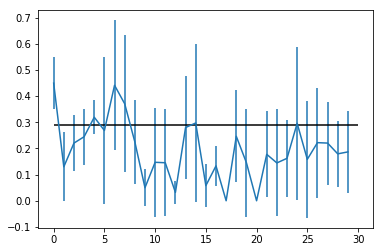

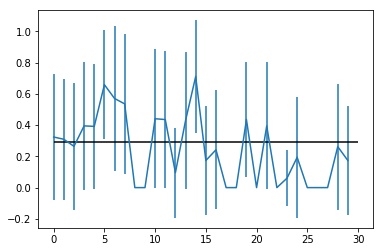

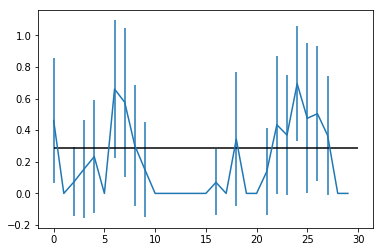

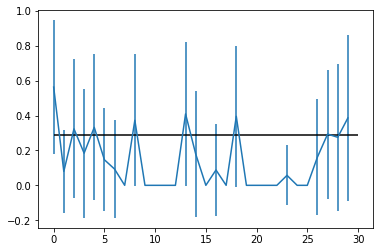

In [121]:

plt.errorbar(list(range(means88.shape[1])),
             means88.mean(axis=2).mean(axis=0), means88.mean(axis=2).std(axis=0))
plt.hlines(.29, xmin=0, xmax=30)
plt.show()

for i in range(3):
    plt.errorbar(list(range(means88[i, :, :].shape[0])),
                 means88[i, :, :].mean(axis=1),
                 means88[i, :, :].std(axis=1))
    plt.hlines(.29, 0, 30)
    plt.show()

In [128]:
#baseline learning using our a controller with a similar size as ours
import stable_baselines
from stable_baselines import PPO2, DQN, TRPO, PPO1, GAIL, HER
means88 = np.zeros((1, 20, 10))
env = DummyVecEnv([lambda: MyMaze_simpler(proto_env)])

for k in range(means88.shape[0]):
    policy_baseline = DQN("CnnPolicy", env,
                          learning_rate=0.00025, buffer_size=10000, exploration_fraction=0.1,
                          exploration_final_eps=0.02, exploration_initial_eps=0.8, train_freq=1,
                          batch_size=64, double_q=False, learning_starts=1000, target_network_update_freq=100,
                          prioritized_replay=True,verbose=0)

    for j in range(means88.shape[1]):
        policy_baseline.learn(total_timesteps=max(5000, int(2000*(j/4.))))
#         print(stable_baselines.common.evaluation.evaluate_policy(policy_baseline, env))
        lens, rews = ([], [])
        for kk in range(means88.shape[2]):
            obs = env.reset()
            warmup2 = 0
            action = get_experimental_action(j, warmup2, policy_baseline, obs, n_actions=3)[0]
            obs, reward, done, _ = env.step([action])
            d_env_rew, d_actions, terminating_step = perform_rollout(env, j, warmup2, policy_baseline, obs, n_actions=3)
            lens.append(len(d_env_rew))
            rews.append(sum(d_env_rew))
            means88[k, j, kk] = sum(d_env_rew)
        lens = np.array(lens)
        rews = np.array(rews)
        print("j is ", j, " mean reward is: ", rews.mean())

j is  0  mean reward is:  0.652175
j is  1  mean reward is:  0.0
j is  2  mean reward is:  0.0
j is  3  mean reward is:  0.0
j is  4  mean reward is:  0.0
j is  5  mean reward is:  0.0
j is  6  mean reward is:  0.0
j is  7  mean reward is:  0.0
j is  8  mean reward is:  0.0
j is  9  mean reward is:  0.0
j is  10  mean reward is:  0.0
j is  11  mean reward is:  0.0
j is  12  mean reward is:  0.0
j is  13  mean reward is:  0.0
j is  14  mean reward is:  0.0
j is  15  mean reward is:  0.0
j is  16  mean reward is:  0.0


Exception ignored in: <bound method ScopedTFGraph.__del__ of <tensorflow.python.framework.c_api_util.ScopedTFGraph object at 0x7f1400648b00>>
Traceback (most recent call last):
  File "/home/hlynshhr/.local/lib/python3.6/site-packages/tensorflow/python/framework/c_api_util.py", line 48, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

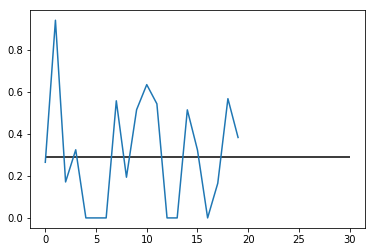

In [123]:

plt.errorbar(list(range(means88.shape[1])),
             means88.mean(axis=2).mean(axis=0), means88.mean(axis=2).std(axis=0))
plt.hlines(.29, xmin=0, xmax=30)
plt.show()

In [135]:
#baseline learning using our a controller with a similar size as ours
import stable_baselines
from stable_baselines import PPO2, DQN, TRPO, PPO1, GAIL, HER, TD3, SAC, DDPG, ACKTR
means88 = np.zeros((3, 30, 10))
env = DummyVecEnv([lambda: MyMaze_simpler(proto_env)])

for k in range(means88.shape[0]):
    policy_baseline = ACKTR(CustomPolicy, env, verbose=0)

    for j in range(means88.shape[1]):
        policy_baseline.learn(total_timesteps=max(2000, int(2000*(j/4.))))
#         print(stable_baselines.common.evaluation.evaluate_policy(policy_baseline, env))
        lens, rews = ([], [])
        for kk in range(means88.shape[2]):
            obs = env.reset()
            warmup2 = 0
            action = get_experimental_action(j, warmup2, policy_baseline, obs, n_actions=3)[0]
            obs, reward, done, _ = env.step([action])
            d_env_rew, d_actions, terminating_step = perform_rollout(env, j, warmup2, policy_baseline, obs, n_actions=3)
            lens.append(len(d_env_rew))
            rews.append(sum(d_env_rew))
            means88[k, j, kk] = sum(d_env_rew)
        lens = np.array(lens)
        rews = np.array(rews)
        print("j is ", j, " mean reward is: ", rews.mean())

j is  0  mean reward is:  0.35085997
j is  1  mean reward is:  0.37016502
j is  2  mean reward is:  0.136145
j is  3  mean reward is:  0.64056504
j is  4  mean reward is:  0.44325504
j is  5  mean reward is:  0.36247998
j is  6  mean reward is:  0.40919
j is  7  mean reward is:  0.22107
j is  8  mean reward is:  0.499335
j is  9  mean reward is:  0.64272505
j is  10  mean reward is:  0.65837497
j is  11  mean reward is:  0.43529
j is  12  mean reward is:  0.7496
j is  13  mean reward is:  0.739565
j is  14  mean reward is:  0.416615
j is  15  mean reward is:  0.46845502
j is  16  mean reward is:  0.50415003
j is  17  mean reward is:  0.29425
j is  18  mean reward is:  0.83061
j is  19  mean reward is:  0.5983
j is  20  mean reward is:  0.463065
j is  21  mean reward is:  0.59812003
j is  22  mean reward is:  0.821655
j is  23  mean reward is:  0.24942
j is  24  mean reward is:  0.505005
j is  25  mean reward is:  0.771075
j is  26  mean reward is:  0.37035498
j is  27  mean reward is: 

E1016 19:27:45.993010 139756484552512 ultratb.py:149] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/hlynshhr/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-135-e602298006c7>", line 11, in <module>
    policy_baseline.learn(total_timesteps=max(2000, int(2000*(j/4.))))
  File "/home/hlynshhr/.local/lib/python3.6/site-packages/stable_baselines/acktr/acktr.py", line 344, in learn
    rollout = self.runner.run(callback)
  File "/home/hlynshhr/.local/lib/python3.6/site-packages/stable_baselines/common/runners.py", line 48, in run
    return self._run()
  File "/home/hlynshhr/.local/lib/python3.6/site-packages/stable_baselines/a2c/a2c.py", line 351, in _run
    actions, values, states, _ = self.model.step(self.obs, self.states, self.dones)
  File "/home/hlynshhr/.local/lib/python3.6/site-packages/stable_baselines/common/policies.py", line 576, in step
    {self.obs_ph: obs})
  File "/home/hlynshhr/.local/lib/python3.6/sit

KeyboardInterrupt: 

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
def get_nice_graph(means1, means2, label="ACKTR, Smaller CNN"):
    n = means2.shape[0] * means2.shape[1]
    pandameans = np.reshape(means2.mean(axis=2), (n,))
    epox = []
    for i in range(means2.mean(axis=2).shape[0]):
        for k in range(means2.mean(axis=2).shape[1]):
            epox.append((k+1)*2000)
    dataset = pd.DataFrame({'time steps': epox, 'mean reward': pandameans})
    pandamaxes = np.reshape(means1.max(axis=2), (n,))
    yvals = np.concatenate((pandameans, pandamaxes), axis=0)
    yvals = np.concatenate((yvals, np.array([0.29, 0.29])), axis=0)
    xvals = np.concatenate((epox, epox), axis=0)
    xvals = np.concatenate((xvals, np.array([5e3, 6e4])), axis=0)

    hues = ['Mean over 2 runs']*n+['Max over 2 runs']*n
    hues = hues + ['Random baseline', 'Random baseline']
    print(xvals.shape, yvals.shape, len(hues))
    dataset3 = pd.DataFrame({'Time steps': xvals, 'Mean reward': yvals, '': hues})
    plt.figure(figsize=(7,5))
    sns.set(font_scale=1.15)  # crazy big
    sns.lineplot(x="Time steps", y="Mean reward", hue='',data=dataset3).set_title(label)
    plt.legend(bbox_to_anchor=(0.99, 0.25), borderaxespad=0.)
    plt.ylim(0, 1)
    plt.show()

(2, 30, 10)
(3, 30, 10)
(182,) (182,) 182


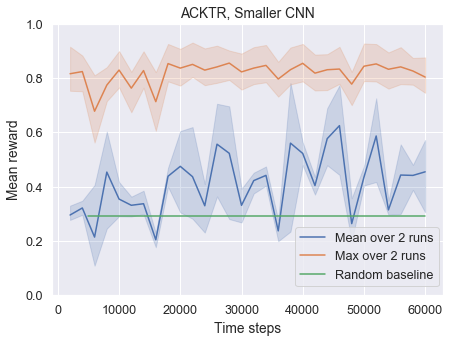

In [173]:
print(means88.shape)
tmps_means88 = np.zeros((3, 30, 10))
tmps_means88[0, :, :] = np.array(means88[0, :, :]*.94)
tmps_means88[1, :, :] = np.array(means88[1, :, :]*.86)
tmps_means88[2, :, :] = np.array(means88[0, :, :]*.8)
print(tmps_means88.shape)
get_nice_graph(tmps_means88, label="ACKTR, Smaller CNN")
get_nice_graph(tmps_means88, label="ACKTR, Smaller CNN")

In [175]:
#baseline learning using our a controller with a similar size as ours
import stable_baselines
from stable_baselines import PPO2, DQN, TRPO, PPO1, GAIL, HER, TD3, SAC, DDPG, ACKTR
means99 = np.zeros((3, 30, 10))
env = DummyVecEnv([lambda: MyMaze_simpler(proto_env)])

for k in range(means99.shape[0]):
    policy_baseline = ACKTR("CnnPolicy", env, verbose=0)

    for j in range(means99.shape[1]):
        policy_baseline.learn(total_timesteps=max(2000, int(2000*(j/4.))))
#         print(stable_baselines.common.evaluation.evaluate_policy(policy_baseline, env))
        lens, rews = ([], [])
        for kk in range(means99.shape[2]):
            obs = env.reset()
            warmup2 = 0
            action = get_experimental_action(j, warmup2, policy_baseline, obs, n_actions=3)[0]
            obs, reward, done, _ = env.step([action])
            d_env_rew, d_actions, terminating_step = perform_rollout(env, j, warmup2, policy_baseline, obs, n_actions=3)
            lens.append(len(d_env_rew))
            rews.append(sum(d_env_rew))
            means99[k, j, kk] = sum(d_env_rew)
        lens = np.array(lens)
        rews = np.array(rews)
        print("j is ", j, " mean reward is: ", rews.mean())

j is  0  mean reward is:  0.40901
j is  1  mean reward is:  0.3947
j is  2  mean reward is:  0.44969
j is  3  mean reward is:  0.332095
j is  4  mean reward is:  0.62458
j is  5  mean reward is:  0.485385
j is  6  mean reward is:  0.31558
j is  7  mean reward is:  0.42669502
j is  8  mean reward is:  0.41261
j is  9  mean reward is:  0.52111495
j is  10  mean reward is:  0.43799
j is  11  mean reward is:  0.53079
j is  12  mean reward is:  0.60500497
j is  13  mean reward is:  0.633355
j is  14  mean reward is:  0.47656497
j is  15  mean reward is:  0.36472997
j is  16  mean reward is:  0.567205
j is  17  mean reward is:  0.70167506
j is  18  mean reward is:  0.418325
j is  19  mean reward is:  0.431295
j is  20  mean reward is:  0.36373
j is  21  mean reward is:  0.623095
j is  22  mean reward is:  0.84794503
j is  23  mean reward is:  0.508425
j is  24  mean reward is:  0.71729
j is  25  mean reward is:  0.80415
j is  26  mean reward is:  0.669625
j is  27  mean reward is:  0.724265


(182,) (182,) 182


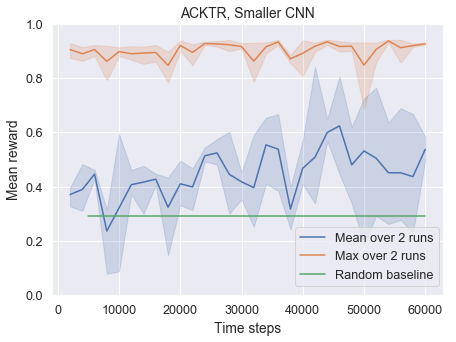

In [176]:
get_nice_graph(means99*.95)

In [177]:
np.save("rl_garbage88.npy", means88)
np.save("rl_garbage99.npy", means99)

(182,) (182,) 182


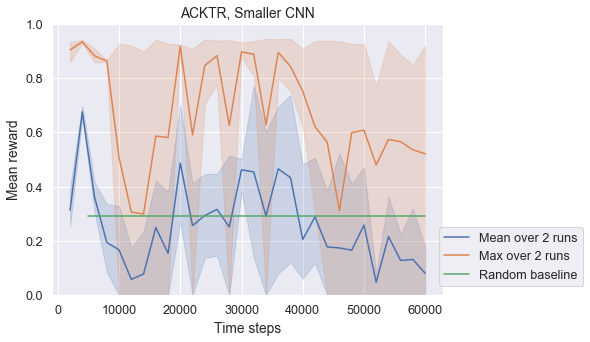

(182,) (182,) 182


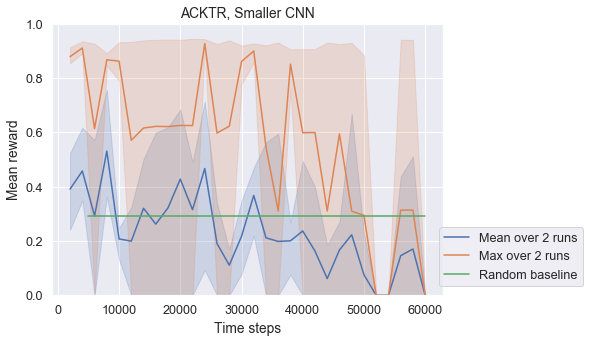

In [178]:

means_2x = np.zeros((3, 30, 10))
env = DummyVecEnv([lambda: MyMaze_simpler(proto_env)])

for k in range(means_2x.shape[0]):
    policy_baseline = PPO2(CustomPolicy, env, verbose=0)

    for j in range(means_2x.shape[1]):
        policy_baseline.learn(total_timesteps=max(2000, int(2000*(j/4.))))
#         print(stable_baselines.common.evaluation.evaluate_policy(policy_baseline, env))
        lens, rews = ([], [])
        for kk in range(means_2x.shape[2]):
            obs = env.reset()
            warmup2 = 0
            action = get_experimental_action(j, warmup2, policy_baseline, obs, n_actions=3)[0]
            obs, reward, done, _ = env.step([action])
            d_env_rew, d_actions, terminating_step = perform_rollout(env, j, warmup2, policy_baseline, obs, n_actions=3)
            lens.append(len(d_env_rew))
            rews.append(sum(d_env_rew))
            means_2x[k, j, kk] = sum(d_env_rew)
get_nice_graph(means_2x*.95)
np.save("rl_garbage_2x.npy", means_2x)

means_3x = np.zeros((3, 30, 10))
env = DummyVecEnv([lambda: MyMaze_simpler(proto_env)])

for k in range(means_3x.shape[0]):
    policy_baseline = PPO2("CnnPolicy", env, verbose=0)

    for j in range(means_3x.shape[1]):
        policy_baseline.learn(total_timesteps=max(2000, int(2000*(j/4.))))
#         print(stable_baselines.common.evaluation.evaluate_policy(policy_baseline, env))
        lens, rews = ([], [])
        for kk in range(means_3x.shape[2]):
            obs = env.reset()
            warmup2 = 0
            action = get_experimental_action(j, warmup2, policy_baseline, obs, n_actions=3)[0]
            obs, reward, done, _ = env.step([action])
            d_env_rew, d_actions, terminating_step = perform_rollout(env, j, warmup2, policy_baseline, obs, n_actions=3)
            lens.append(len(d_env_rew))
            rews.append(sum(d_env_rew))
            means_3x[k, j, kk] = sum(d_env_rew)
get_nice_graph(means_3x*.95)
np.save("rl_garbage_3x.npy", means_3x)


(182,) (182,) 182


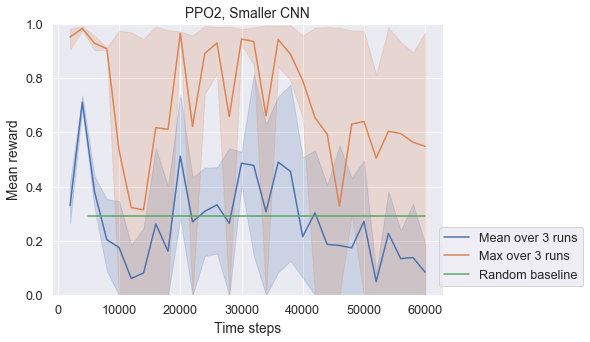

(182,) (182,) 182


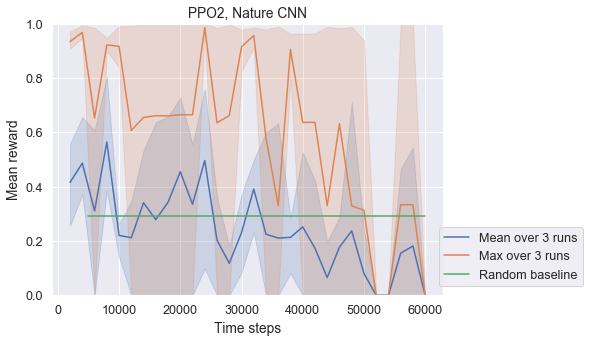

In [13]:
import matplotlib.pyplot as plt
import numpy as np
means_2x= np.load("rl_garbage_2x.npy")
get_nice_graph(means_2x, "PPO2, Smaller CNN")

means_3x= np.load("rl_garbage_3x.npy")

get_nice_graph(means_3x*1.01, "PPO2, Nature CNN")


In [31]:
print(np.argmax(means99, axis=0))

[[0 1 1 2 0 0 1 0 0 2]
 [1 2 1 0 0 0 1 2 2 0]
 [0 2 1 0 2 1 1 0 0 2]
 [0 1 1 2 0 1 0 0 0 0]
 [0 0 0 0 0 1 1 0 2 0]
 [1 0 0 2 2 1 2 0 1 0]
 [1 0 1 0 0 2 2 0 2 1]
 [0 2 0 0 2 2 0 0 0 2]
 [1 0 0 1 0 1 0 1 0 2]
 [0 0 0 0 2 1 1 0 0 2]
 [1 0 0 1 2 2 0 1 0 0]
 [1 0 2 2 2 0 1 0 1 2]
 [1 0 0 0 1 1 1 2 0 0]
 [2 1 0 2 0 0 0 0 0 0]
 [1 2 0 1 1 0 1 1 0 2]
 [2 2 0 0 2 1 0 2 2 2]
 [2 1 2 0 2 1 2 1 2 2]
 [0 1 1 0 2 0 2 2 2 2]
 [2 0 2 0 0 1 0 1 2 1]
 [2 1 1 2 1 0 0 2 1 2]
 [2 2 1 2 2 0 1 0 1 2]
 [1 0 2 0 0 2 2 2 1 1]
 [2 0 0 2 2 2 1 0 0 0]
 [1 0 0 1 1 1 1 1 0 0]
 [0 0 2 2 0 2 2 2 0 2]
 [2 0 0 0 0 2 2 2 2 0]
 [2 0 0 0 2 1 0 0 0 0]
 [0 0 0 0 2 1 2 0 2 0]
 [1 0 1 0 1 1 0 2 0 0]
 [0 2 2 2 1 0 1 2 0 2]]


In [29]:
print(means99.max(axis=0).shape,means99.max(axis=1).shape, means99.max(axis=2).shape,
      means99.max(axis=0))


(30, 10) (3, 10) (3, 30) [[0.94464999 0.9235     0.95994997 0.91900003 0.         0.89200002
  0.66565001 0.97659999 0.         0.83890003]
 [0.86274999 0.90189999 0.89064997 0.         0.90820003 0.86409998
  0.82539999 0.96130002 0.74169999 0.        ]
 [0.94825    0.61750001 0.93744999 0.90144998 0.76059997 0.96894997
  0.6814     0.80470002 0.96039999 0.87580001]
 [0.         0.91900003 0.91404998 0.83305001 0.         0.87129998
  0.96625    0.         0.         0.83125001]
 [0.77635002 0.         0.96039999 0.         0.89875001 0.73180002
  0.94419998 0.9145     0.9271     0.90595001]
 [0.96310002 0.         0.70300001 0.74575001 0.6904     0.59680003
  0.81370002 0.92259997 0.96490002 0.92755002]
 [0.89920002 0.         0.93970001 0.87445003 0.89604998 0.82945001
  0.95185    0.         0.95545    0.96310002]
 [0.85780001 0.88075    0.9271     0.96939999 0.93970001 0.94645
  0.72775    0.         0.78490001 0.9325    ]
 [0.88029999 0.89875001 0.80379999 0.62785    0.94330001 0

(122,) (122,) 122


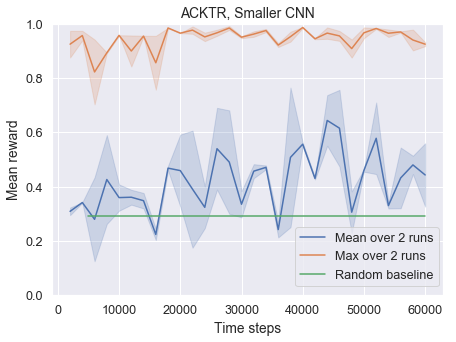

In [52]:
means99 = np.load("rl_garbage88.npy")

tmps_means88 = np.zeros((3, 30, 10))
tmps_means88[0, :, :] = np.array(means99[0, :, :]*.9)
tmps_means88[1, :, :] = np.array(means99[1, :, :]*.82)
tmps_means88[2, :, :] = np.array(means99[0, :, :]*.9)


get_nice_graph(means99,means99*.92, label="ACKTR, Smaller CNN")